In [ ]:
from cmlreaders import CMLReader, get_data_index
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sb
import scipy
from scipy import stats

In [84]:
BAI_high = 15
BAI_low = 8
BDI_high = 16
BDI_low = 10

sel_sub = pd.DataFrame([])
demographics = pd.read_excel(r'./All_neuropsych.xlsx',engine="openpyxl") #read master spreadsheet of all RAM subjects demo/neuropsych data


In [99]:
# demographics['subject']=np.zeros(len(demographics))*np.nan # set a new columns with Nans
sub_mat=list(np.zeros(len(demographics))*np.nan )
df = get_data_index('r1')
# df_select = pd.DataFrame([])
for sub in df['subject'].unique():
    num = int(sub[2:5])
    for i in demographics.index:
        sel = demographics.iloc[i]['Subject Number']
        if sel == num:
            sub_mat[i]=sub
# df_select[0:50]
demographics['subject']=sub_mat
demographics

,Subject Number,Event Name,Study site,Gender,Years of Education,Age of seizure onset,Age at Implant (calculated),Phase II Implant Date,Phase III Implant Date,Traumatic Brain Injury (TBI) Notes,...,FSIQ,GAI,VCI,PRI,Pre-operative Report,Prior Neurosurgical Procedures (can select more than one),Prior Surgery: Resection Detail,Prior Surgery: Callosotomy Detail,Prior Surgery: Laser Ablation Detail,subject
0,1,Subject Consent & Surgery,University of Pennsylvania,Female,13.0,20.0,48.105026,2014-10-08,NaT,NaN,...,72,76.0,81,75,REP001_neurospych.pdf,NaN,NaN,NaN,NaN,R1001P
1,2,Subject Consent & Surgery,University of Pennsylvania,Female,16.0,34.0,49.383743,2014-11-12,NaT,NaN,...,86,84.0,89,84,R1002P_neuropsych.pdf,NaN,NaN,NaN,NaN,R1002P
2,3,Subject Consent & Surgery,University of Pennsylvania,Female,13.0,37.0,39.390382,2014-11-13,NaT,motor vehicle accident due to loss of consciou...,...,102,NaN,107,100,R1003P_neuropsych.pdf,NaN,NaN,NaN,NaN,R1003P
3,4,Subject Consent & Surgery,Dartmouth University,Female,12.0,6.0,51.918931,2014-11-06,NaT,"In early 90s, motor vehicle accident resulting...",...,72,NaN,78,82,R1004D Neuropsych.pdf,NaN,NaN,NaN,NaN,R1004D
4,5,Subject Consent & Surgery,University of Pennsylvania,Female,NaN,NaN,20.304432,2015-01-14,NaT,NaN,...,80,89.0,98,82,R1005P_neuropsych.pdf,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
591,592,Subject Consent & Surgery,Emory University,Female,15.0,9.0,21.843022,2021-11-10,NaT,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
592,593,Subject Consent & Surgery,Dartmouth University,Female,20.0,2.0,37.408138,2021-11-29,NaT,NaN,...,100,104.0,100,109,R1593D_Neuropsych_15Mar2021.pdf,VNS implant,NaN,NaN,NaN,NaN
593,594,Subject Consent & Surgery,Emory University,Male,16.0,36.0,38.276054,2021-11-17,NaT,NaN,...,NaN,107.0,114,100,R1594E-Neuropsychologic Report_redacted.pdf,NaN,NaN,NaN,NaN,R1594E
594,595,Subject Consent & Surgery,UT Southwestern,Female,NaN,NaN,20.950464,2021-11-23,NaT,NaN,...,70,74.0,5,6,R1595T.docx,NaN,NaN,NaN,NaN,NaN


In [8]:
trial_df = pd.DataFrame([])
list_df = pd.DataFrame([])

experiments = ['FR1', 'catFR1']

for sub in df_select['subject']:
#   try:
    for exp in experiments:
        localizations=df[(df['subject']==sub) & (df['experiment']==exp)]['localization'].unique()        

        for loc in localizations:
            montages = df[(df['subject']==sub) & (df['experiment']==exp) & (df['localization']==loc)]['montage'].unique()            

            for mont in montages: # iterate over montages            
                data = df[np.logical_and(df["subject"] == sub, df['experiment']==exp)]
                sessions=data[np.logical_and(data['montage']==mont,data['localization']==loc)]['session'].unique()

                for sess in sessions: 
                    reader = CMLReader(sub, exp, sess, montage=mont, localization=loc)   #reader for loading CML data
                    evs = reader.load('task_events')
                    word_evs = evs[evs['type']=='REC_WORD']

                    #exclude practice lists 
                    lists = len(word_evs['list'][word_evs['list']>0].unique()) 
                    corr_recs = len(word_evs[word_evs['intrusion']==0])
                    ELIs = len(word_evs[word_evs['intrusion']==-1])
                    PLIs = len(word_evs[word_evs['intrusion']>0])
                    total_ints = ELIs + PLIs
                    total_trials = corr_recs + total_ints

                    trials = [] #make list of event numbers of analysis
                    for list_num in word_evs['list'][word_evs['list']>0].unique():
                        list_events=word_evs[word_evs['list']==list_num]
                        if len(list_events)>0: 
                            for i in range(0,len(list_events)):
                                trials.append(list_events.index[i])
                        PLI = len(list_events[list_events['intrusion']>0])
                        ELI = len(list_events[list_events['intrusion']==-1])
                        correc = len(list_events[list_events['intrusion']==0])
                        row = df_select[df_select['subject']==sub] #get row of BAI/BDI scores for subject
                        BAI = row['BAI'].item()
                        BDI = row['BDI'].item()
#                         if np.isnan(row['BAI'].item())==False and np.isnan(row['BDI'].item())==False:
#                             BAI = int(row['BAI'])
#                             BDI = int(row['BDI'])
#                         elif np.isnan(row['BAI'].item())==True:
#                             BAI = np.nan
#                             BDI = int(row['BDI'])
#                         elif np.isnan(row['BDI'].item())==True:
#                             BAI = int(row['BAI'])
#                             BDI = np.nan
                        list_df = list_df.append({ #create dataframe of events for analysis grouped by list ##should I filter out lists with no events?
                            'subject':sub,
                            'session': sess,
                            'experiment': exp,
                            'list': list_num,
                            'number of correct recalls': correc,
                            'number of extra-list intrusions': ELI,
                            'number of prior-list intrusions': PLI,
                            'total number of intrusions': ELI+PLI,
                            'BAI':BAI,
                            'BDI':BDI
                            },ignore_index=True) 
                    trial_df = trial_df.append({ #create dataframe of events for analysis grouped by session
                        'subject':sub,
                        'session': sess,
                        'montage': mont,
                        'localization': loc,
                        'experiment': exp,
                        'number of lists': lists,
                        'number of correct recalls': corr_recs,
                        'number of extra-list intrusions': ELIs,
                        'number of prior-list intrusions': PLIs,
                        'total number of intrusions': total_ints,
                        'total number of trials left': total_trials,
                        'trials for analysis': trials
                        },ignore_index=True) 
#     except:
#         print('Failed for subject:', sub)
list_df[:100]

,BAI,BDI,experiment,list,number of correct recalls,number of extra-list intrusions,number of prior-list intrusions,session,subject,total number of intrusions
0,8.0,2.0,FR1,2.0,2.0,0.0,2.0,0.0,R1001P,2.0
1,8.0,2.0,FR1,3.0,4.0,3.0,1.0,0.0,R1001P,4.0
2,8.0,2.0,FR1,4.0,2.0,3.0,1.0,0.0,R1001P,4.0
3,8.0,2.0,FR1,7.0,2.0,2.0,0.0,0.0,R1001P,2.0
4,8.0,2.0,FR1,8.0,3.0,1.0,1.0,0.0,R1001P,2.0
...,...,...,...,...,...,...,...,...,...,...
95,7.0,7.0,FR1,1.0,4.0,1.0,0.0,0.0,R1006P,1.0
96,7.0,7.0,FR1,2.0,3.0,1.0,1.0,0.0,R1006P,2.0
97,7.0,7.0,FR1,3.0,3.0,1.0,0.0,0.0,R1006P,1.0
98,7.0,7.0,FR1,4.0,5.0,1.0,1.0,0.0,R1006P,2.0


In [9]:
any(np.isnan(list_df['BDI']))
# list_df.query("subject=='R1014D'")

True

109

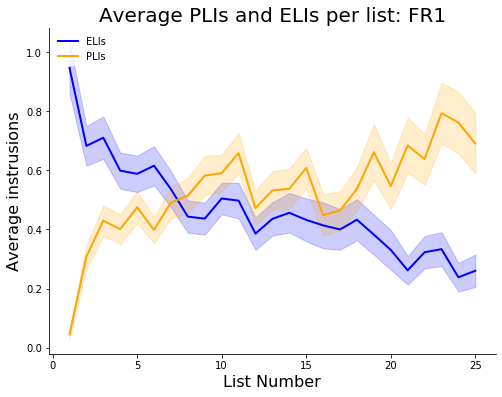

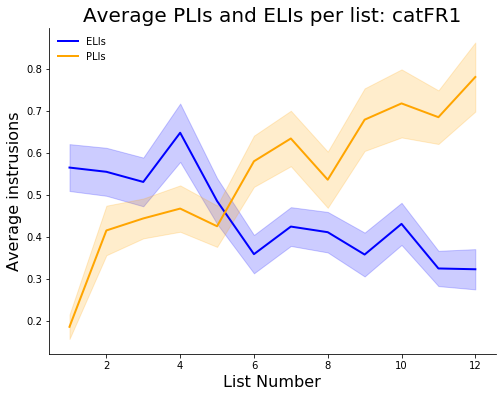

In [12]:
#BEGINNING OF LIST-LEVEL ANALYSES
experiments = ['FR1', 'catFR1']
colors = ['blue', 'orange']

#Create dataframe of recall type averaged over list number
exp_sum_df = pd.DataFrame([])
for exp in experiments:
    if exp=='FR1':
        nlist = 25
    elif exp=='catFR1': ##there are 30 subjects who ran CatFR1 with 25 lists rather than 12. Need to figure out how to interpret the second half of those sessions
        nlist = 12
    for i in range(1,nlist+1):
        exp_list_df = list_df[list_df['experiment']==exp]
        list_sel = exp_list_df[exp_list_df['list']==i]
        correc = np.mean(list_sel['number of correct recalls'])
        ELI = np.mean(list_sel['number of extra-list intrusions'])
        ELI_sem = scipy.stats.sem(list_sel['number of extra-list intrusions'],axis=0,ddof=1,nan_policy='omit')
        PLI = np.mean(list_sel['number of prior-list intrusions'])
        PLI_sem = scipy.stats.sem(list_sel['number of prior-list intrusions'],axis=0,ddof=1,nan_policy='omit')
        exp_sum_df = exp_sum_df.append({
            'experiment':list_sel.iloc[0]['experiment'],
            'list':i,
            'average correct recalls':correc,
            'average ELIs':ELI,
            'ELI_sem':ELI_sem,
            'average PLIs':PLI,
            'PLI_sem':PLI_sem
        }, ignore_index=True)
    
    sel_sum_df = exp_sum_df.query("experiment=='"+exp+"'")
    #sel_sum_df = exp_sum_df[exp_sum_df['experiment']==exp]
    lst = list(sel_sum_df['list'])
    meanELIs = sel_sum_df['average ELIs']
    meanPLIs = sel_sum_df['average PLIs']
    semELIs = sel_sum_df['ELI_sem']
    semPLIs = sel_sum_df['PLI_sem']
    
    plt.figure(figsize=(8,6))
    plt.plot(lst,meanELIs,linewidth=2,color=colors[0])
    plt.fill_between(lst,meanELIs-semELIs,meanELIs+semELIs,color=colors[0],alpha=0.2)
    plt.plot(lst,meanPLIs,linewidth=2,color=colors[1])
    plt.fill_between(lst,meanPLIs-semPLIs,meanPLIs+semPLIs,color=colors[1],alpha=0.2)
    plt.title('Average PLIs and ELIs per list: '+exp, fontsize=20)
    plt.xlabel('List Number',fontsize=16)
    plt.ylabel('Average instrusions',fontsize=16)
    plt.legend(('ELIs','PLIs'),loc='upper left',edgecolor="None")
    plt.gca().spines['right'].set_color('none')
    plt.gca().spines['top'].set_color('none')
    #plt.savefig('PLIvELI '+ exp+ '.pdf')

len(list_df[list_df['experiment']=='FR1']['subject'].unique())
# long_cat = list_df[np.logical_and(list_df['experiment']==exp, list_df['list']>12)]
# long_cat['subject'].unique()

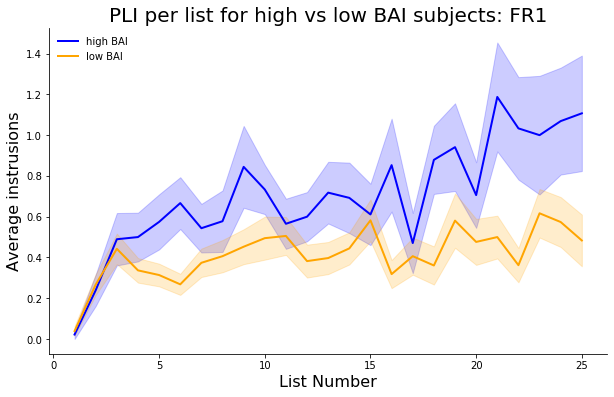

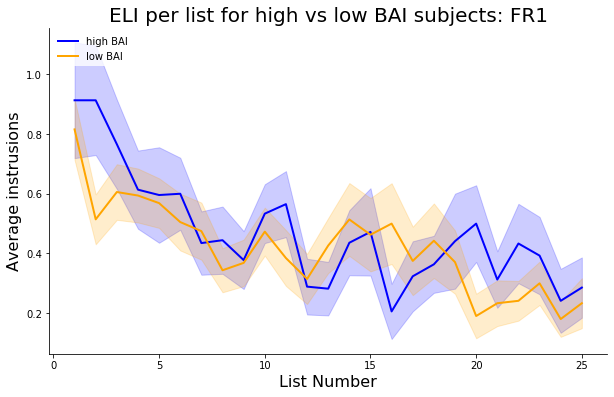

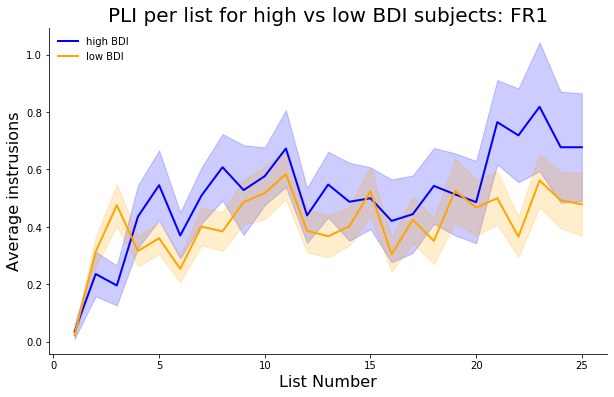

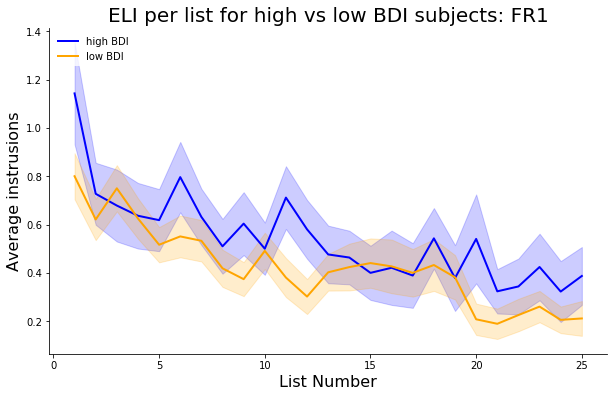

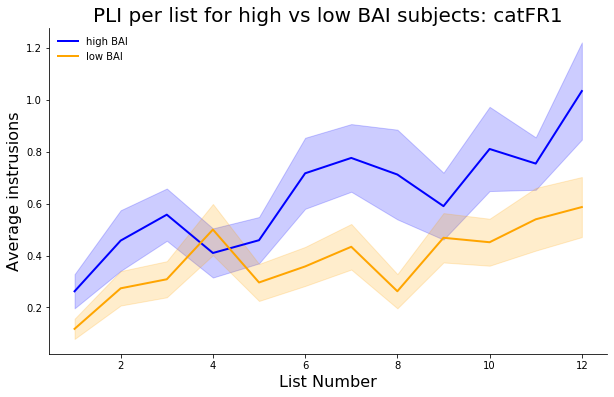

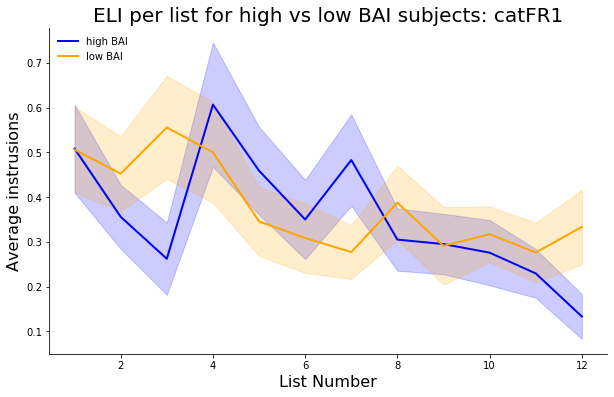

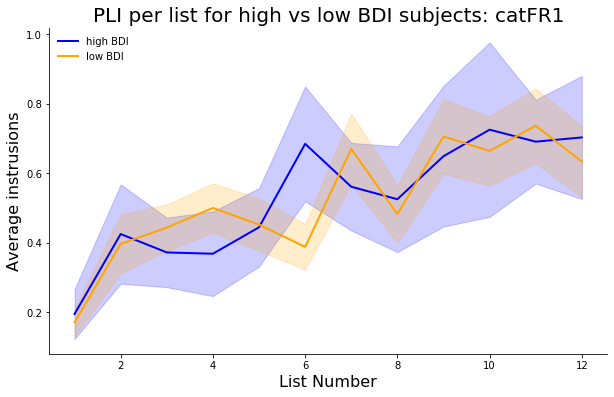

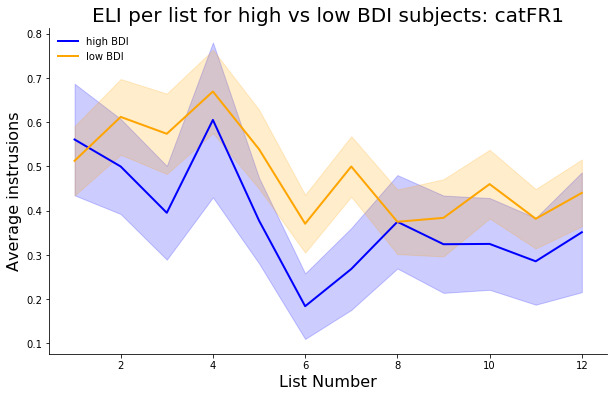

In [13]:
dependents = ['PLI', 'ELI']
metrics = ['BAI','BDI']
levels = ['high','low']

#Compare high and low BAI/BDI subjects for each type of intrusions by list in both experiments
for exp in experiments:
    for met in metrics:
        for dep in dependents:
            split_sum_df = pd.DataFrame([])
            exp_list_df = list_df[list_df['experiment']==exp]
            exp_list_df_highA = exp_list_df[exp_list_df['BAI']>BAI_high]
            exp_list_df_lowA = exp_list_df[exp_list_df['BAI']<BAI_low]
            exp_list_df_highD = exp_list_df[exp_list_df['BDI']>BDI_high]
            exp_list_df_lowD = exp_list_df[exp_list_df['BDI']<BDI_low]
            if exp=='FR1':
                nlist = 25
            elif exp=='catFR1':
                nlist = 12
            if met=='BAI':
                exp_list_df_high = exp_list_df_highA
                exp_list_df_low = exp_list_df_lowA
            elif met=='BDI':
                exp_list_df_high = exp_list_df_highD
                exp_list_df_low = exp_list_df_lowD
            for lev in levels:
                if lev =='high':
                    exp_list_df_filt = exp_list_df_high
                elif lev=='low':
                    exp_list_df_filt = exp_list_df_low
                for i in range(1,nlist+1):
                    list_sel = exp_list_df_filt[exp_list_df_filt['list']==i]
                    correc = np.mean(list_sel['number of correct recalls'])
                    correc_sem = scipy.stats.sem(list_sel['number of correct recalls'],axis=0,ddof=1,nan_policy='omit')
                    ELI = np.mean(list_sel['number of extra-list intrusions'])
                    ELI_sem = scipy.stats.sem(list_sel['number of extra-list intrusions'],axis=0,ddof=1,nan_policy='omit')
                    PLI = np.mean(list_sel['number of prior-list intrusions'])
                    PLI_sem = scipy.stats.sem(list_sel['number of prior-list intrusions'],axis=0,ddof=1,nan_policy='omit')
                    split_sum_df = split_sum_df.append({
                        'experiment':list_sel.iloc[0]['experiment'],
                        'list':i,
                        'average correct recalls':correc,
                        'correct recall_sem':correc,
                        'average ELIs':ELI,
                        'ELI_sem':ELI_sem,
                        'average PLIs':PLI,
                        'PLI_sem':PLI_sem,
                        'metric':met,
                        'level':lev
                    }, ignore_index=True)
            lst = list(split_sum_df['list'].unique())
            high_ints = list(split_sum_df[split_sum_df['level']=='high']['average '+dep+'s'])
            low_ints = list(split_sum_df[split_sum_df['level']=='low']['average '+dep+'s'])
            sem_high = split_sum_df[split_sum_df['level']=='high'][dep+'_sem']
            sem_low = split_sum_df[split_sum_df['level']=='low'][dep+'_sem']

            plt.figure(figsize=(10,6))
            plt.plot(lst,high_ints,linewidth=2,color=colors[0])
            plt.fill_between(lst,high_ints-sem_high,high_ints+sem_high,color=colors[0],alpha=0.2)
            plt.plot(lst,low_ints,linewidth=2,color=colors[1])
            plt.fill_between(lst,low_ints-sem_low,low_ints+sem_low,color=colors[1],alpha=0.2)
            plt.title(dep+' per list for high vs low '+met+' subjects: '+exp, fontsize=20)
            plt.xlabel('List Number',fontsize=16)
            plt.ylabel('Average instrusions',fontsize=16)
            plt.legend(('high '+met,'low '+met),loc='upper left',edgecolor="None")
            plt.gca().spines['right'].set_color('none')
            plt.gca().spines['top'].set_color('none')
            #plt.savefig(dep+' per list for high vs low '+met+' subjects: '+exp+'.pdf')

In [17]:
#BEGINNING OF SESSION LEVEL ANALYSES
df_filter = pd.DataFrame([])
#Create dataframe of important session stats. Scale PLIs, ELIs, and correct recalls. Add BAI/BDI scores.
for i in trial_df.index:
    try:
        sub = trial_df.iloc[i]['subject']
        row = df_select[df_select['subject'] == sub]
        eli = trial_df.iloc[i]['number of extra-list intrusions']
        pli = trial_df.iloc[i]['number of prior-list intrusions']
        correc = trial_df.iloc[i]['number of correct recalls']
        allrec = trial_df.iloc[i]['total number of trials left']
        lists = trial_df.iloc[i]['number of lists']
        exp = trial_df.iloc[i]['experiment']
        PLI_scaled = float(pli/correc) ##Need to confirm scaling method with Mike
        ELI_scaled = float(eli/correc)
        correc_scaled = float(correc/lists)
#         PLI_scaled = float(pli/allrec) 
#         ELI_scaled = float(eli/allrec)
#         correc_scaled = float(correc/allrec)
        if allrec > 0: #remove sessions with no valid recalls
            df_filter = df_filter.append({
                'subject':sub,
                'experiment':exp,
                'correct recalls':correc,
                'ELIs':eli,
                'PLIs':pli,
                'total ints': eli+pli,
                'lists':lists,
                'correct recalls scaled':correc_scaled,
                'all recalls':allrec,
                'ELI scaled':ELI_scaled,
                'PLI scaled':PLI_scaled,
                'total scaled':ELI_scaled+PLI_scaled,
                'BAI':row['BAI'].item(),
                'BDI':row['BDI'].item()
            }, ignore_index = True)
        else:
            print('removed row =', i, sub, exp)
    except:
        print('Analysis failed for row =', i, sub, exp)
df_filter

/home1/noaherz/.conda/envs/cml3/lib/python3.7/site-packages/ipykernel_launcher.py:14: RuntimeWarning: invalid value encountered in double_scalars
  
/home1/noaherz/.conda/envs/cml3/lib/python3.7/site-packages/ipykernel_launcher.py:15: RuntimeWarning: invalid value encountered in double_scalars
  from ipykernel import kernelapp as app
/home1/noaherz/.conda/envs/cml3/lib/python3.7/site-packages/ipykernel_launcher.py:16: RuntimeWarning: invalid value encountered in double_scalars
  app.launch_new_instance()


removed row = 9 R1015J FR1
removed row = 100 R1100D FR1
removed row = 101 R1100D FR1


,BAI,BDI,ELI scaled,ELIs,PLI scaled,PLIs,all recalls,correct recalls,correct recalls scaled,experiment,lists,subject,total ints,total scaled
0,8.0,2.0,0.338710,21.0,0.403226,25.0,108.0,62.0,2.818182,FR1,22.0,R1001P,46.0,0.741935
1,8.0,2.0,0.301587,19.0,0.269841,17.0,99.0,63.0,2.739130,FR1,23.0,R1001P,36.0,0.571429
2,9.0,0.0,0.025641,3.0,0.068376,8.0,128.0,117.0,4.680000,FR1,25.0,R1002P,11.0,0.094017
3,9.0,0.0,0.016667,2.0,0.025000,3.0,125.0,120.0,4.800000,FR1,25.0,R1002P,5.0,0.041667
4,7.0,7.0,0.084906,9.0,0.198113,21.0,136.0,106.0,4.240000,FR1,25.0,R1006P,30.0,0.283019
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
470,2.0,7.0,0.021739,2.0,0.010870,1.0,95.0,92.0,7.666667,FR1,12.0,R1542J,3.0,0.032609
471,2.0,7.0,0.033333,3.0,0.022222,2.0,95.0,90.0,7.500000,FR1,12.0,R1542J,5.0,0.055556
472,2.0,7.0,0.063830,6.0,0.010638,1.0,101.0,94.0,7.833333,FR1,12.0,R1542J,7.0,0.074468
473,2.0,7.0,0.022472,2.0,0.011236,1.0,92.0,89.0,7.416667,catFR1,12.0,R1542J,3.0,0.033708


total PLI = 2375.0
total ELI = 1900.0
mean diff = 0.6167625268158032
median diff = 0.0


Text(0.6167625268158032, 15, '  Mean: 0.0')

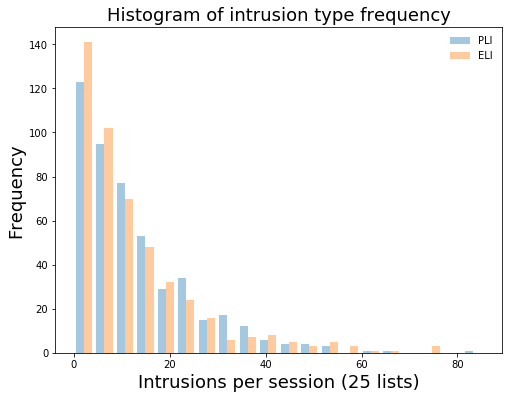

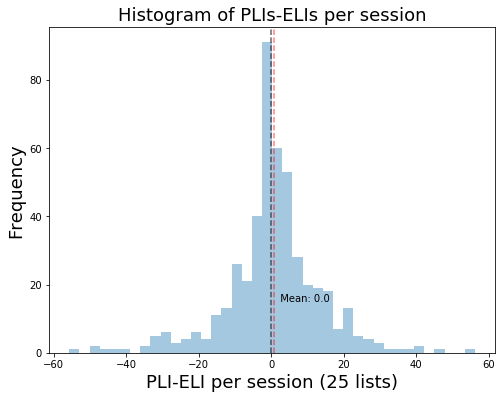

In [18]:
#get intrusion per session counts to generate a histogram
df_int = pd.DataFrame([])
for i in df_filter.index:
    sub = df_filter.iloc[i]['subject']
    exp = df_filter.iloc[i]['experiment']
    PLI = df_filter.iloc[i]['PLIs']
    ELI = df_filter.iloc[i]['ELIs']
    lists = df_filter.iloc[i]['lists']
    sPLI = float(PLI/lists)*25
    sELI = float(ELI/lists)*25
    diff = sPLI-sELI
    df_int = df_int.append({
        'subject':sub,
        'experiment':exp,
        'ELIs':eli,
        'PLIs':pli,
        'lists':lists,
        'ELIs per session':sELI,
        'PLIs per session':sPLI,
        'PLI minus ELI per session':diff,
    }, ignore_index=True)

total_PLI = np.sum(df_int['PLIs'])
total_ELI = np.sum(df_int['ELIs'])
PLI_list = list(df_int['PLIs per session'])
ELI_list = list(df_int['ELIs per session'])
diff_list = list(df_int['PLI minus ELI per session'])

plt.figure(figsize=(8,6))
int_hist = plt.hist((PLI_list, ELI_list), 20,alpha=0.4)
plt.xlabel('Intrusions per session (25 lists)',fontsize=18)
plt.ylabel('Frequency',fontsize=18)
plt.title('Histogram of intrusion type frequency',fontsize=18)
plt.legend(('PLI','ELI'),loc='upper right',edgecolor="None")
plt.savefig('Histogram of intrusion type frequency.pdf')

print('total PLI =', total_PLI)
print('total ELI =', total_ELI)

plt.figure(figsize=(8,6))
diff_hist = plt.hist(diff_list, 40,alpha=0.4)
plt.xlabel('PLI-ELI per session (25 lists)',fontsize=18)
plt.ylabel('Frequency',fontsize=18)
plt.title('Histogram of PLIs-ELIs per session',fontsize=18)

mean = np.mean(diff_list)
median = np.median(diff_list)

plt.axvline(x=mean, color='r', linestyle='--',alpha=0.5)
plt.axvline(x=median, color='k', linestyle='--',alpha=0.6)
print('mean diff =', mean)
print('median diff =', median)

plt.text(mean,15,'  Mean: %.1f' %(mean/30))
#plt.savefig('Histogram of PLIs-ELIs per session.pdf')

In [19]:
#average across sessions from the same subject
avg_df = pd.DataFrame([])
sub_df = df_filter['subject'].unique()

for exp in experiments:
    exp_df_filter = df_filter[df_filter['experiment']==exp]
    exp_sub_df = exp_df_filter['subject'].unique()
    for sub in exp_sub_df:
        trials = exp_df_filter[exp_df_filter['subject']==sub]
        df_mean = trials.mean(axis=0)
        avg_eli = df_mean['ELI scaled']
        avg_pli = df_mean['PLI scaled']
        avg_int = df_mean['total scaled']
        avg_cor = df_mean['correct recalls scaled']
        avg_df = avg_df.append({
            'subject':sub,
            'experiment':exp,
            'average ELIs':avg_eli,
            'average PLIs':avg_pli,
            'average ints': avg_int,
            'average correct recalls':avg_cor,
            'BAI':df_mean['BAI'],
            'BDI':df_mean['BDI']
            }, ignore_index = True)

any(np.isnan(avg_df['BDI']))
#len(avg_df[avg_df['experiment']=='catFR1']['subject'].unique())

True

In [21]:
mean=np.mean(avg_df[avg_df['experiment']=='FR1']['average ints'])
std=np.std(avg_df[avg_df['experiment']=='FR1']['average ints'], ddof=1)

print(avg_df[avg_df['experiment']=='FR1']['average ints'].std(ddof=1))
print(std)

0.635905904655194
0.635905904655194


In [40]:
FR_avg_df = avg_df.query("experiment == 'FR1'")
catFR_avg_df = avg_df.query("experiment == 'catFR1'")

FR_stats = FR_avg_df[['average ELIs', 'average PLIs', 'average correct recalls', 'average ints']]
catFR_stats = catFR_avg_df[['average ELIs', 'average PLIs', 'average correct recalls', 'average ints']]

FR_df_zscore = (FR_stats - FR_stats.mean())/FR_stats.std()
catFR_df_zscore = (catFR_stats - catFR_stats.mean())/catFR_stats.std()


FR_avg_df.rename(columns = {'average ELIs':'zELI','average PLIs':'zPLI', 'average ints':'zints',
                              'average correct recalls':'zcorrect'}, inplace = True)

catFR_avg_df.rename(columns = {'average ELIs':'zELI','average PLIs':'zPLI', 'average ints':'zints',
                              'average correct recalls':'zcorrect'}, inplace = True)


full_df=pd.concat((FR_avg_df,catFR_avg_df))

#any(np.isnan(full_df['BDI']))
full_df #Not sure what is up with these warnings

/home1/noaherz/.conda/envs/cml3/lib/python3.7/site-packages/pandas/core/frame.py:4133: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,


,BAI,BDI,zELI,zPLI,zcorrect,zints,experiment,subject
0,8.0,2.0,0.320148,0.336534,2.778656,0.656682,FR1,R1001P
1,9.0,0.0,0.021154,0.046688,4.740000,0.067842,FR1,R1002P
2,7.0,7.0,0.109761,0.127903,4.120000,0.237663,FR1,R1006P
3,2.0,1.0,0.052945,0.159774,2.456522,0.212719,FR1,R1010J
4,0.0,2.0,0.029412,0.220588,2.833333,0.250000,FR1,R1018P
...,...,...,...,...,...,...,...,...
202,5.0,6.0,0.062500,0.187500,3.200000,0.250000,catFR1,R1526J
203,18.0,16.0,0.025938,0.121146,9.638889,0.147085,catFR1,R1530J
204,12.0,21.0,0.229508,0.672131,5.083333,0.901639,catFR1,R1533J
205,24.0,17.0,0.064203,0.238134,4.001894,0.302337,catFR1,R1536J


In [41]:
#Create dataframe that averages values for subjects that ran both experiments into one data point 
# not a good idea... we should leave then seperate.
full_df_comb = pd.DataFrame([])
for sub in full_df['subject'].unique():
    sub_df = full_df[full_df['subject']==sub]
    if len(sub_df) > 1:
        avg_sub_df = sub_df.mean(axis=0)
        exp = 'both'
    else:
        avg_sub_df = sub_df
        exp = str(sub_df['experiment'].values) ##All the dataframes in this cell keep outputting all info for a cell instead of values
    full_df_comb = full_df_comb.append({
        'subject':sub,
        'experiment':exp,
        'average ELIs':float(avg_sub_df['average ELIs']),
        'average PLIs':float(avg_sub_df['average PLIs']),
        'average ints':float(avg_sub_df['average ints']),
        'average correct recalls':float(avg_sub_df['average correct recalls']),
        'zELI':float(avg_sub_df['zELI']),
        'zPLI':float(avg_sub_df['zPLI']),
        'zints':float(avg_sub_df['zints']),
        'zcorrect':float(avg_sub_df['zcorrect']),
        'BAI':avg_sub_df['BAI'].item(),
        'BDI':avg_sub_df['BDI'].item()
        }, ignore_index = True)

full_df_comb
#any(np.isnan(full_df_comb['BDI']))

KeyError: 'average ELIs'

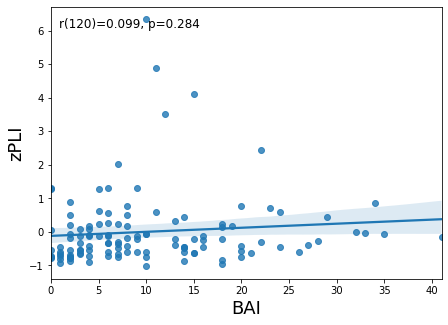

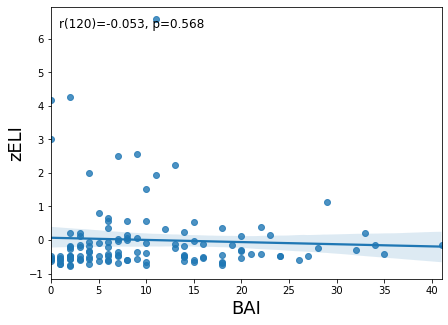

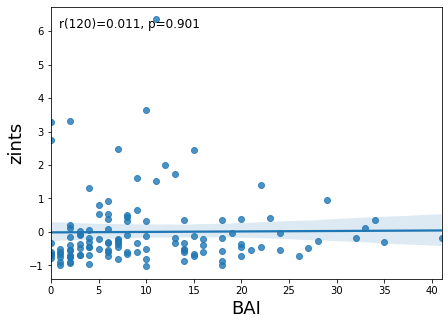

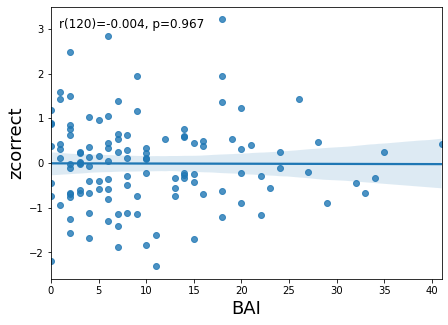

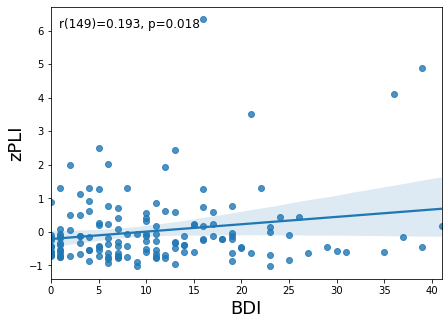

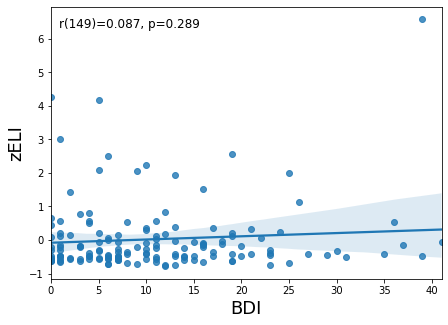

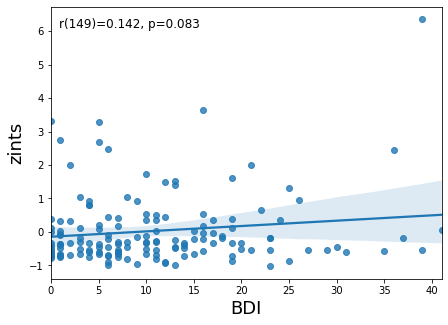

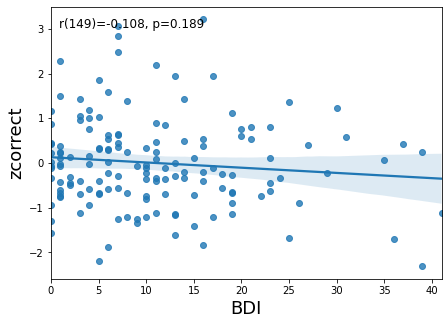

In [356]:
xs = ['BAI', 'BDI']
ys = ['zPLI', 'zELI', 'zints', 'zcorrect']
exp = 'both' 

#Generate graphs for normalized values vs BAI and BDI score
for xi in xs:
    for yi in ys:
        if exp == 'FR1':
            sel_df = full_df.query("experiment=='FR1'")
        elif exp == 'catFR1':
            sel_df = full_df.query("experiment=='catFR1'")
        elif exp == 'both':
            sel_df = full_df_comb
        
        sel_df = sel_df.dropna(subset=[xi])
        x = sel_df[xi]
        y = sel_df[yi]
        n = len(sel_df)

        coef = np.polyfit(x, y, 1)
        poly1d_fn = np.poly1d(coef)
        grad, inter, r, p, std_err = stats.linregress(x, y)

        plt.figure(figsize=(7, 5))
        # plt.scatter(x, y)
        # plt.plot(x, poly1d_fn(x), '--k')
        # max_x = round(x.max(axis = 0) + 5, 5)
        # max_y = round(y.max(axis = 0) + 5, 5)
        # plt.xticks(np.arange(0, max_x, 5))
        # plt.yticks(np.arange(0, max_y, 10))
        plt.xlabel(xi,fontsize=18)
        plt.ylabel(yi,fontsize=18)
#         print('r = ',r, 'p = ', p)
#         print('y =', grad, '*x + ', inter)
#         plt.text(x.min()+2, y.max()-1, f"p = " + str(round(p, 4)) + '\n' + "y = " + str(grad) + "*x + " + str(inter) + '\n' + 'R = ' + str(round(r, 4)) + '\n' + 'N = ' + str(n))
        plt.text(x.min()+float(np.ptp(x)/50), y.max()-float(np.ptp(y)/30), 'r(%.0f)=%.3f, p=%.3f '%(len(x),r,p),fontsize=12)
        g = sb.regplot(data = df_filter, x=x, y=y)
#         plt.title(xi + ' vs ' + yi)
        #plt.savefig(xi +' vs '+ yi + ': ' + exp +'.pdf')
        # ax.set_xlim(0, 25)
        # ax.set_xticks(range(0,25), 5)
